*First compiled on May 5th, 2017.*

### Scanpy analysis of 3k PBMC following a Seurat Tutorial

This reproduces most of Seurat's tutorial available from http://satijalab.org/seurat/pbmc-tutorial.html, as compiled on March 30, 2017. The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x ([here](https://support.10xgenomics.com/single-cell/datasets/pbmc3k), section *Chromium Demonstration (v1 Chemistry)* in [datasets](https://support.10xgenomics.com/single-cell/datasets)).

In [2]:
%config InlineBackend.figure_formats = ['png2x']  # for higher quality, set 'svg'
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3                # show some output
sc.settings.set_dpi(70)                  # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.1+121.g37d0b76 on 2017-07-18 02:04.


Load the data into an `AnnData` object `adata` which consists of the data matrix `adata.X`, sample/cell annotation `adata.smp` and variable/gene annotation `adata.var` and additional unstructured annotation `adata.add`.

For a large file, this takes a longer time only when first reading the `.mtx` text file.

Read the gene/variable and sample names using a standard numpy function.

In [3]:
filename_data = './data/pbmc3k_filtered_gene_bc_matrices/hg19/matrix.mtx'
filename_genes = './data/pbmc3k_filtered_gene_bc_matrices/hg19/genes.tsv'
filename_barcodes = './data/pbmc3k_filtered_gene_bc_matrices/hg19/barcodes.tsv'
adata = sc.read(filename_data).transpose()
adata.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata.smp_names = np.genfromtxt(filename_barcodes, dtype=str)

Basic filtering.

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

... filtered out 0 cells that have less than 200 genes expressed
... filtered out 19024 genes that are detected in less than 3 cells


Plot some information about mitochondrial genes, important for quality control

In [5]:
mito_genes = np.array([name for name in adata.var_names if name.startswith('MT-')])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as sample annotation to adata
adata.smp['n_counts'] = np.sum(adata.X, axis=1).A1

A violin plot of the computed quality measures.

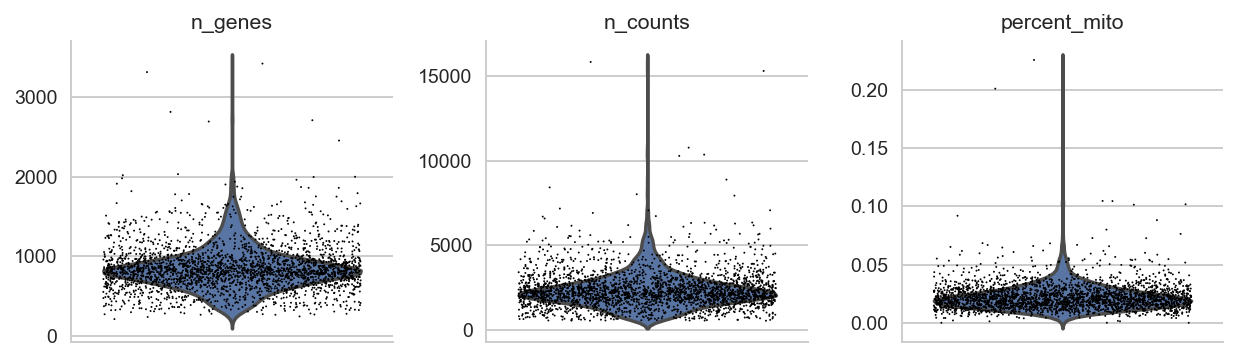

In [6]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

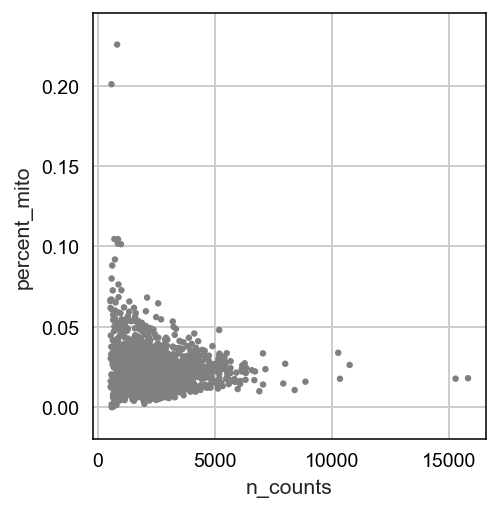

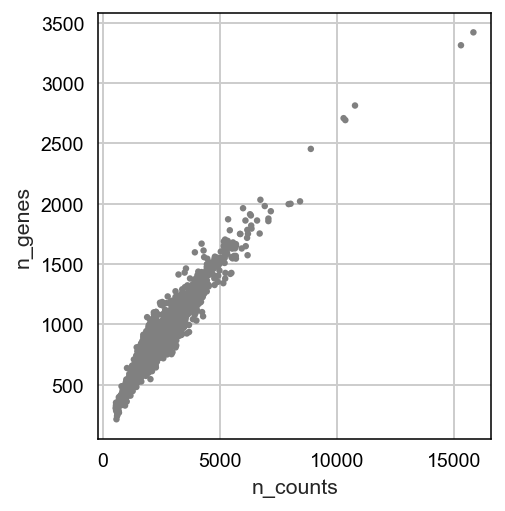

In [7]:
axs = sc.pl.scatter(adata, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [8]:
adata = adata[adata.smp['n_genes'] < 2500, :]
adata = adata[adata.smp['percent_mito'] < 0.05, :]

Save the raw gene expression for later use in differential testing.

In [9]:
sc.write('pbmc3k_filtered_raw', adata)

writing ./write/pbmc3k_filtered_raw.h5


Per-cell normalize the data matrix $X$, identify highly-variable genes and compute logarithm.

... filtered out 0 cells that have less than 1 counts
... normalizing by total count per cell (0:00:00.016)
... filter highly varying genes by dispersion and mean (0:00:00.091)
    using `min_disp=0.5`, `max_disp=None`, `min_mean=0.0125` and `max_mean=3`
--> set `n_top_genes` to simply select top-scoring genes instead


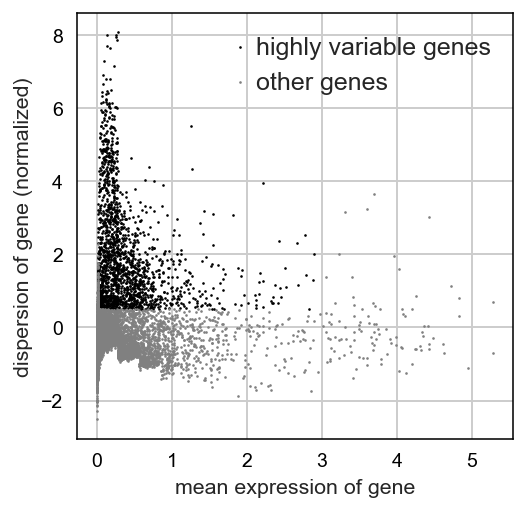

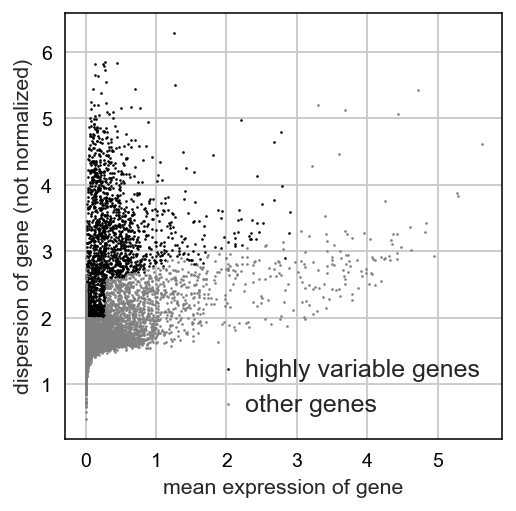

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering and logarithmize the data.

In [11]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [12]:
adata_corrected = sc.pp.regress_out(adata, ['n_counts', 'percent_mito'],
                                    copy=True)

regress out ['n_counts', 'percent_mito']
... sparse input is densified and may lead to huge memory consumption

finished (0:00:08.078)
--> after `sc.pp.regress_out`, consider rescaling the adata using `sc.pp.scale`


In [13]:
sc.pp.scale(adata_corrected, max_value=10)

... clipping at max_value 10


Compute PCA and make a scatter plot.

compute PCA with n_comps = 50
    finished (0:00:00.951) and added
    "X_pca", the PCA coordinates (adata.smp)
    "PC1", "PC2", ..., the loadings (adata.var)
    "pca_variance_ratio", the variance ratio (adata.add)


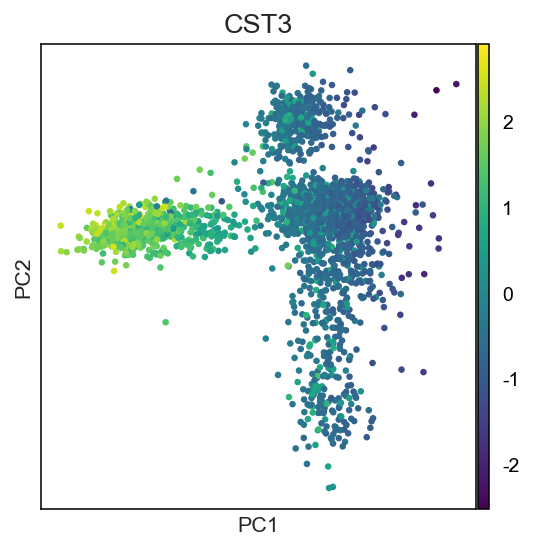

In [14]:
sc.tl.pca(adata_corrected)
adata_corrected.smp['X_pca'] *= -1  # multiply by 1 for correspondence with R
axs = sc.pl.pca_scatter(adata_corrected, color='CST3', right_margin=0.2)

Also, look at the contribution of single genes to PCs and of PCs to the total variance in the data.

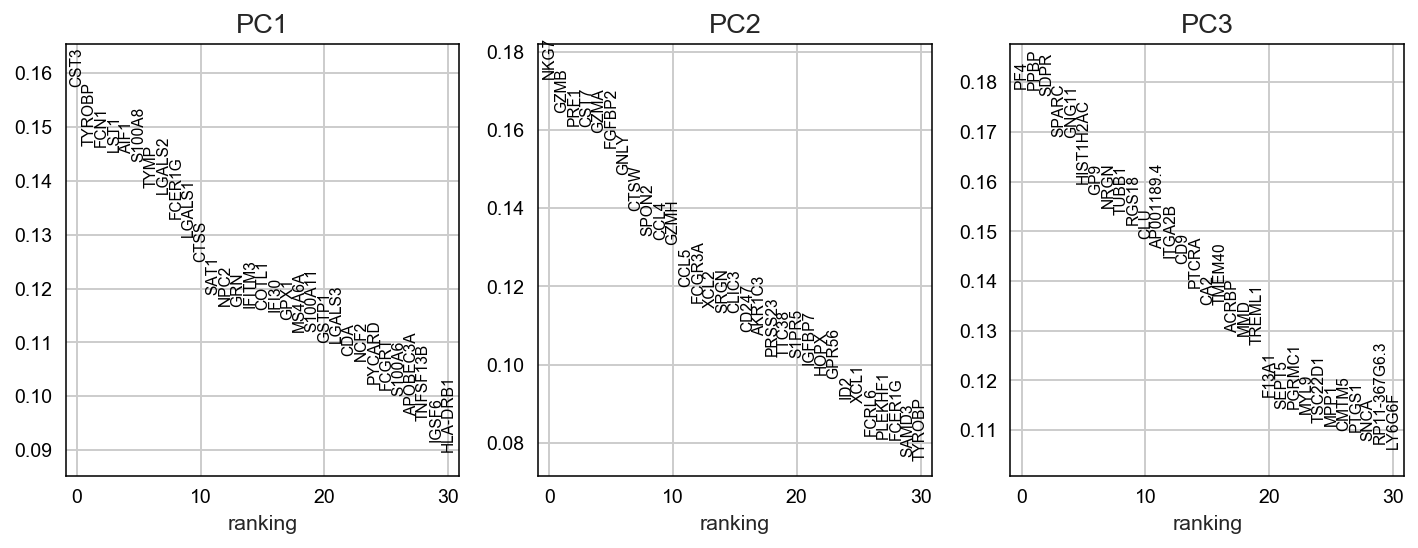

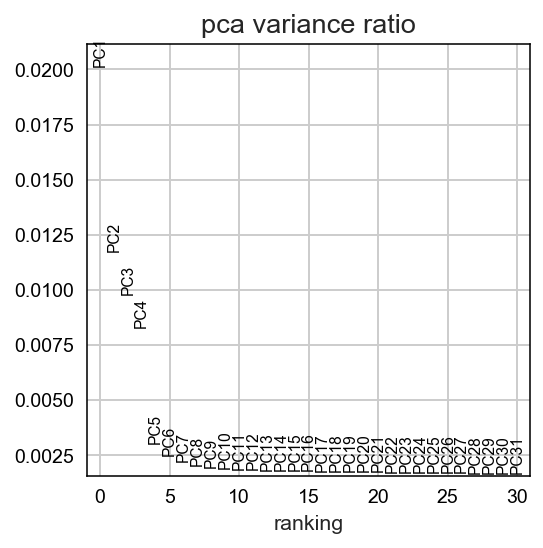

In [15]:
sc.pl.pca_ranking(adata_corrected)

In [16]:
sc.tl.tsne(adata_corrected, n_pcs=10)

compute tSNE
    using X_pca for tSNE
    using 10 principal components
    using package MulticoreTSNE
    finished (0:00:07.303) and added
    "X_tsne", tSNE coordinates (adata.smp)


Here, we use the Louvain graph clustering method (community detection based on optimizing modularity), the clustering that seems to have become most widely accepted.

In [17]:
sc.tl.louvain(adata_corrected, n_neighbors=10, resolution=1.3, recompute_graph=True)

run Louvain clustering
initializing data graph with `n_neighbors=10`
    using X_pca for building graph
    finished (0:00:01.023) and found 8 clusters, added
    "louvain_groups", the cluster labels (adata.smp)
    "louvain_groups_names", the unique cluster labels (adata.add)


Plot the data with tSNE. Coloring according to clustering.

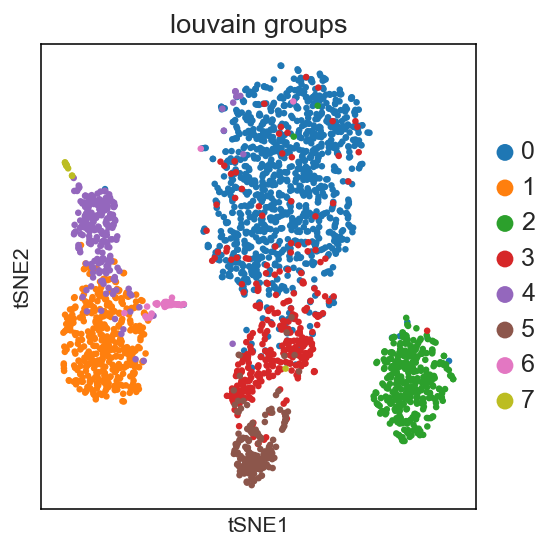

In [18]:
axs = sc.pl.tsne(adata_corrected, color='louvain_groups')

Save this, in case we need it later.

In [19]:
sc.write('pbmc3k_corrected', adata_corrected)

writing ./write/pbmc3k_corrected.h5


Let us compute a ranking for the highly differential genes in each cluster. This is a very simple method and but agrees quite well with the more advanced tests of Seurat.

For this, we use raw data.

reading file ./write/pbmc3k_corrected.h5
reading file ./write/pbmc3k_filtered_raw.h5
find differentially expressed genes
consider "louvain_groups": ['0' '1' '2' '3' '4' '5' '6' '7'] with sample numbers [1110  417  340  328  219  166   42   16]
    finished (0:00:00.946) and added
    "diffrank_zscores", the rankings for each genes (adata.add)


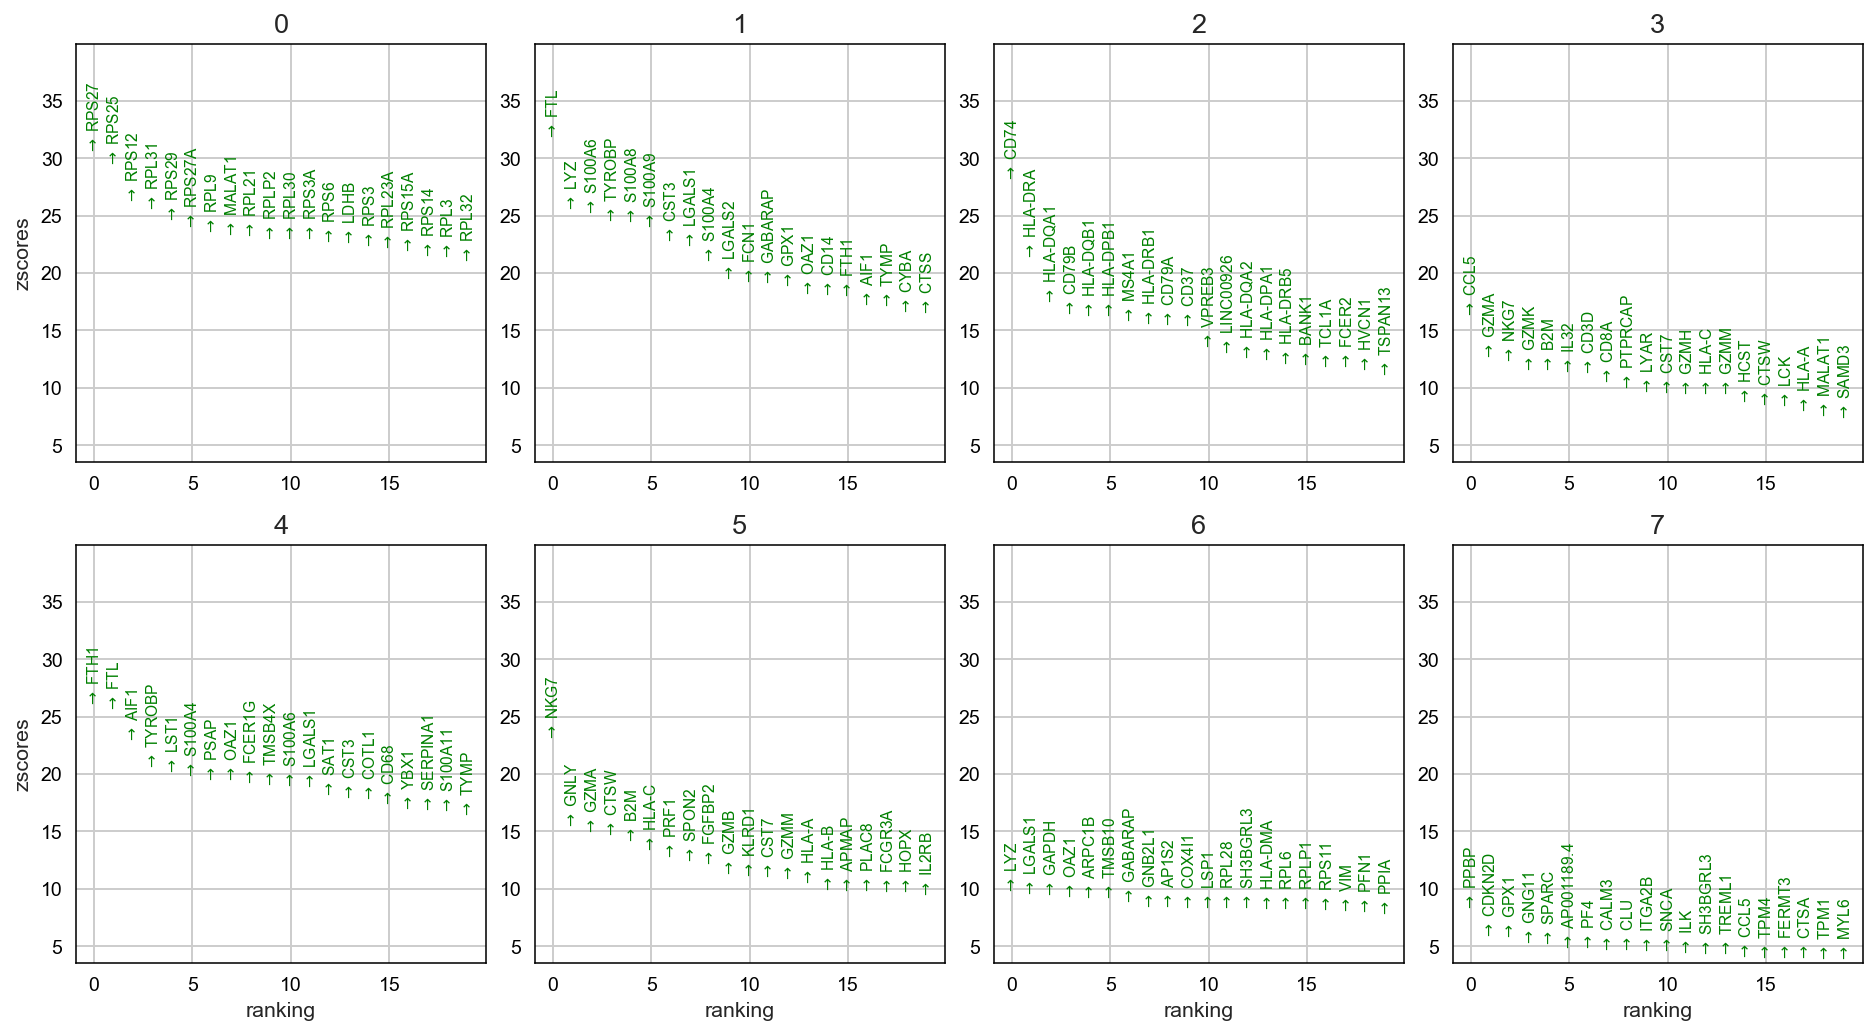

In [20]:
adata_corrected = sc.read('pbmc3k_corrected')
adata = sc.read('pbmc3k_filtered_raw')
adata.smp['louvain_groups'] = adata_corrected.smp['louvain_groups']
adata.add['louvain_groups_names'] = adata_corrected.add['louvain_groups_names']
sc.tl.diffrank(adata, 'louvain_groups')
sc.pl.diffrank(adata)

We observe most of the marker genes pointed out in the [Seurat Tutorial](http://satijalab.org/seurat/pbmc-tutorial.html) to be present in these rankings, and can hence identify the cell types.

Cluster ID | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
5 |	GNLY, NKG7 | 	NK cells
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes

In [21]:
adata_corrected.add['louvain_groups_names'] = [
    "CD4 T cells", "CD14+ Monocytes", 
    "B cells", "CD8 T cells", 
    "FCGR3A+ Monocytes", "NK cells", "Dendritic cells", 
    "Megakaryocytes"]

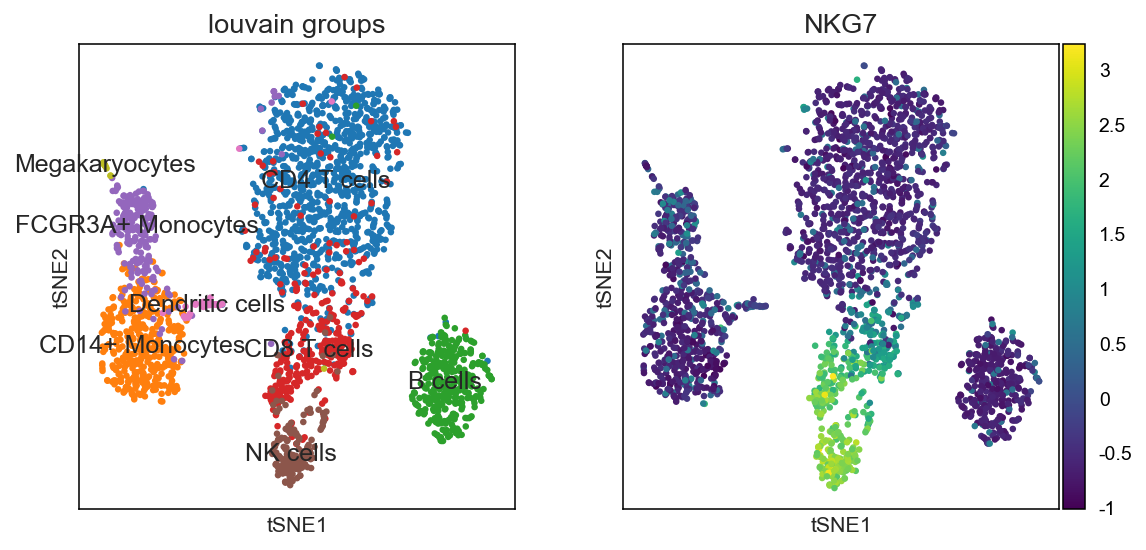

In [22]:
axs = sc.pl.tsne(adata_corrected, 
                 color=['louvain_groups', 'NKG7'],
                 legend_loc='on data')

In [23]:
sc.write('pbmc3k_corrected', adata_corrected)

writing ./write/pbmc3k_corrected.h5


If you want to export to "csv", simply provide the file extension.

In [24]:
sc.write('./write/pbmc3k_corrected.csv', adata_corrected)
# sc.write('pbmc3k_corrected', adata_corrected, ext='csv')  # is equivalent to previous line

writing csv files to ./write/pbmc3k_corrected/
